In [1]:
!pip -q install -U transformers==4.44.2 datasets==2.19.1 peft==0.12.0 scikit-learn matplotlib -q
import os, random
import numpy as np
import matplotlib
matplotlib.use("Agg") 
import matplotlib.pyplot as plt
from collections import Counter
import torch
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
SEED = 2002
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
set_seed(SEED)
ds_raw = load_dataset("SetFit/tweet_sentiment_extraction")
wanted_cols = ["text", "label"]
ds_raw = DatasetDict({
    "train": ds_raw["train"].remove_columns([c for c in ds_raw["train"].column_names if c not in wanted_cols]),
    "test" : ds_raw["test"].remove_columns([c for c in ds_raw["test"].column_names if c not in wanted_cols])})
print("Label mapping: 0=Negative, 1=Neutral, 2=Positive")
print("Original TRAIN label distribution:", Counter(ds_raw["train"]["label"]))
print("Original TEST label distribution:", Counter(ds_raw["test"]["label"]))
y = np.array(ds_raw["train"]["label"])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=SEED)
train_idx, valid_idx = next(sss.split(np.zeros_like(y), y))
train_split = ds_raw["train"].select(train_idx)
valid_split = ds_raw["train"].select(valid_idx)
ds = DatasetDict(train=train_split, validation=valid_split, test=ds_raw["test"])
print("TRAIN label distribution:", Counter(ds["train"]["label"]))
print("VALID label distribution:", Counter(ds["validation"]["label"]))
print("TEST label distribution:", Counter(ds["test"]["label"]))
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
ds_token = ds.map(tokenize_fn, batched=True)
ds_token.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
train_dataset = ds_token["train"]
valid_dataset = ds_token["validation"]
test_dataset  = ds_token["test"]
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "macro_f1": f1_score(labels, preds, average="macro"),}
COMMON_ARGS = dict(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",   
    greater_is_better=True,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.06,
    fp16=True,
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
    seed=SEED,)
model_full = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
args_full = TrainingArguments(output_dir="./results/full", learning_rate=2e-5, **COMMON_ARGS)
trainer_full = Trainer(
    model=model_full, args=args_full,
    train_dataset=train_dataset, eval_dataset=valid_dataset,
    tokenizer=tokenizer, compute_metrics=compute_metrics)
print("Starting Full FT...")
trainer_full.train()
print("Full FT finished.")
model_lora = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
target_modules = ["q_lin", "k_lin", "v_lin"] 
lora_config = LoraConfig(
    r=8, lora_alpha=16, lora_dropout=0.1, bias="none",
    task_type=TaskType.SEQ_CLS, target_modules=target_modules)
model_lora = get_peft_model(model_lora, lora_config)
model_lora.print_trainable_parameters()
args_lora = TrainingArguments(output_dir="./results/lora", learning_rate=2e-4, **COMMON_ARGS)
trainer_lora = Trainer(
    model=model_lora, args=args_lora,
    train_dataset=train_dataset, eval_dataset=valid_dataset,
    tokenizer=tokenizer, compute_metrics=compute_metrics)
print("Starting LoRA FT...")
trainer_lora.train()
print("LoRA FT finished.")
full_test_out = trainer_full.predict(test_dataset)
lora_test_out = trainer_lora.predict(test_dataset)
def summarize_test(name, out):
    preds = np.argmax(out.predictions, axis=-1)
    acc  = accuracy_score(out.label_ids, preds)
    wf1  = f1_score(out.label_ids, preds, average="weighted")
    mf1  = f1_score(out.label_ids, preds, average="macro")
    print(f"[{name}] Test Accuracy={acc:.4f} | Weighted-F1={wf1:.4f} | Macro-F1={mf1:.4f}")
    return preds, {"accuracy":acc, "weighted_f1":wf1, "macro_f1":mf1}
print("Final TEST results:")
full_preds, full_scores = summarize_test("Full Fine-tuning", full_test_out)
lora_preds, lora_scores = summarize_test("LoRA Fine-tuning", lora_test_out)
def per_class_report(y_true, y_pred, title, save_path):
    print(f"\n===== {title}: Per-class metrics (TEST) =====")
    print(classification_report(y_true, y_pred, digits=4, target_names=["Negative(0)","Neutral(1)","Positive(2)"]))
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    fig = plt.figure(figsize=(4.5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{title} - Confusion Matrix (TEST)")
    plt.xticks([0,1,2], ["Negative(0)","Neutral(1)","Positive(2)"], rotation=45)
    plt.yticks([0,1,2], ["Negative(0)","Neutral(1)","Positive(2)"])
    for (i,j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha='center', va='center')
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
    plt.savefig(save_path, dpi=180); plt.close(fig)
per_class_report(test_dataset["label"], full_preds, "Full FT", "./full_confusion_test.png")
per_class_report(test_dataset["label"], lora_preds, "LoRA", "./lora_confusion_test.png")
print("Saved confusion matrices: full_confusion_test.png / lora_confusion_test.png")
def extract_history(trainer):
    hist = trainer.state.log_history
    train_loss_pairs, eval_loss_pairs, eval_f1_pairs = [], [], []
    for rec in hist:
        if rec.get("loss") is not None and rec.get("epoch") is not None:
            train_loss_pairs.append((rec["epoch"], rec["loss"]))
        if rec.get("eval_loss") is not None and rec.get("epoch") is not None:
            eval_loss_pairs.append((rec["epoch"], rec["eval_loss"]))
        if rec.get("eval_f1") is not None and rec.get("epoch") is not None:
            eval_f1_pairs.append((rec["epoch"], rec["eval_f1"]))
    def last_per_epoch(pairs):
        d={}
        for e,v in pairs:
            d[e]=v
        xs = sorted(d.keys())
        return xs, [d[e] for e in xs]
    e_tr, y_tr = last_per_epoch(train_loss_pairs) if train_loss_pairs else ([],[])
    e_ev, y_ev = last_per_epoch(eval_loss_pairs) if eval_loss_pairs else ([],[])
    e_f1, y_f1 = last_per_epoch(eval_f1_pairs) if eval_f1_pairs else ([],[])
    return (e_tr, y_tr), (e_ev, y_ev), (e_f1, y_f1)
def plot_learning_curves(trainer, tag):
    (e_tr, y_tr), (e_ev, y_ev), (e_f1, y_f1) = extract_history(trainer)
    if y_tr:
        plt.figure(figsize=(5,3.2))
        plt.plot(e_tr, y_tr, marker='o', label='Train Loss')
        if y_ev:
            plt.plot(e_ev, y_ev, marker='o', label='Valid Loss')
        plt.title(f"{tag} - Loss Curve"); plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.legend(); plt.tight_layout(); plt.savefig(f"./{tag.lower()}_loss_curve.png", dpi=180); plt.close()
    if y_f1:
        plt.figure(figsize=(5,3.2))
        plt.plot(e_f1, y_f1, marker='o', label='Valid Weighted-F1')
        plt.title(f"{tag} - Valid F1 Curve"); plt.xlabel("Epoch"); plt.ylabel("F1")
        plt.legend(); plt.tight_layout(); plt.savefig(f"./{tag.lower()}_f1_curve.png", dpi=180); plt.close()
plot_learning_curves(trainer_full, "Full")
plot_learning_curves(trainer_lora, "LoRA")
print("Saved learning curves: full_loss_curve.png / full_f1_curve.png / lora_loss_curve.png / lora_f1_curve.png")
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def count_all_params(model):
    return sum(p.numel() for p in model.parameters())
summary = {
    "Full": {
        "all_params": count_all_params(model_full),
        "trainable_params": count_trainable_params(model_full),
        **full_scores
    },
    "LoRA": {
        "all_params": count_all_params(model_lora),
        "trainable_params": count_trainable_params(model_lora),
        **lora_scores
    }
}
print("\n===== Summary =====")
for k,v in summary.items():
    ratio = v["trainable_params"]/v["all_params"] if v["all_params"] else 0.0
    print(f"{k}: trainable={v['trainable_params']:,} / total={v['all_params']:,} "
          f"({ratio*100:.2f}%), Test Acc={v['accuracy']:.4f}, "
          f"Weighted-F1={v['weighted_f1']:.4f}, Macro-F1={v['macro_f1']:.4f}")
trainer_full.save_model("./best_full")
trainer_lora.save_model("./best_lora")
print("Models saved: ./best_full / ./best_lora")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 73.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 113.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 109.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 78.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.3 MB/s eta 0:00:00

2025-10-17 07:09:11.856733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760684952.228907      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760684952.344894      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/27481 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3534 [00:00<?, ? examples/s]

Label mapping: 0=Negative, 1=Neutral, 2=Positive
Original TRAIN label distribution: Counter({1: 11118, 2: 8582, 0: 7781})
Original TEST label distribution: Counter({1: 1430, 2: 1103, 0: 1001})
TRAIN label distribution: Counter({1: 10006, 2: 7723, 0: 7003})
VALID label distribution: Counter({1: 1112, 2: 859, 0: 778})
TEST label distribution: Counter({1: 1430, 2: 1103, 0: 1001})


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/24732 [00:00<?, ? examples/s]

Map:   0%|          | 0/2749 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting Full FT...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Macro F1
1,0.555500,0.538350,0.779192,0.779926,0.782993
2,0.441100,0.538777,0.785013,0.785221,0.789089


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Full FT finished.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


trainable params: 814,083 || all params: 67,769,862 || trainable%: 1.2012
Starting LoRA FT...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Macro F1
1,0.573700,0.575172,0.760276,0.760706,0.764451
2,0.540600,0.560059,0.771190,0.771357,0.774617


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


LoRA FT finished.


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Final TEST results:
[Full Fine-tuning] Test Accuracy=0.7954 | Weighted-F1=0.7957 | Macro-F1=0.7989
[LoRA Fine-tuning] Test Accuracy=0.7804 | Weighted-F1=0.7809 | Macro-F1=0.7841

===== Full FT: Per-class metrics (TEST) =====
              precision    recall  f1-score   support

 Negative(0)     0.7877    0.8082    0.7978      1001
  Neutral(1)     0.7593    0.7699    0.7646      1430
 Positive(2)     0.8524    0.8169    0.8343      1103

    accuracy                         0.7954      3534
   macro avg     0.7998    0.7983    0.7989      3534
weighted avg     0.7964    0.7954    0.7957      3534


===== LoRA: Per-class metrics (TEST) =====
              precision    recall  f1-score   support

 Negative(0)     0.7644    0.7942    0.7790      1001
  Neutral(1)     0.7428    0.7531    0.7479      1430
 Positive(2)     0.8487    0.8033    0.8253      1103

    accuracy                         0.7804      3534
   macro avg     0.7853    0.7835    0.7841      3534
weighted avg     0.7819 

full_confusion_test.png
lora_f1_curve.png
lora_loss_curve.png
full_loss_curve.png
full_f1_curve.png
lora_confusion_test.png


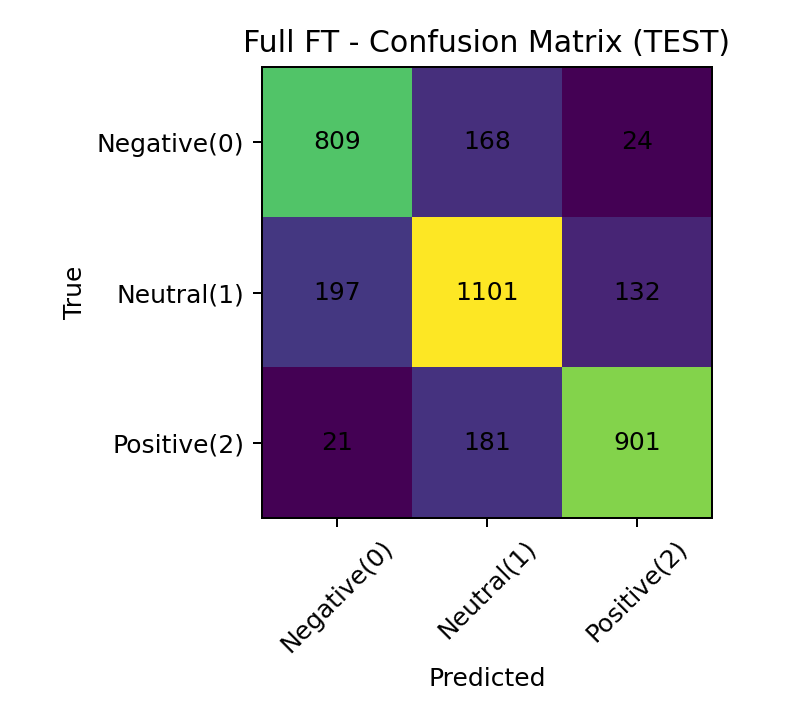

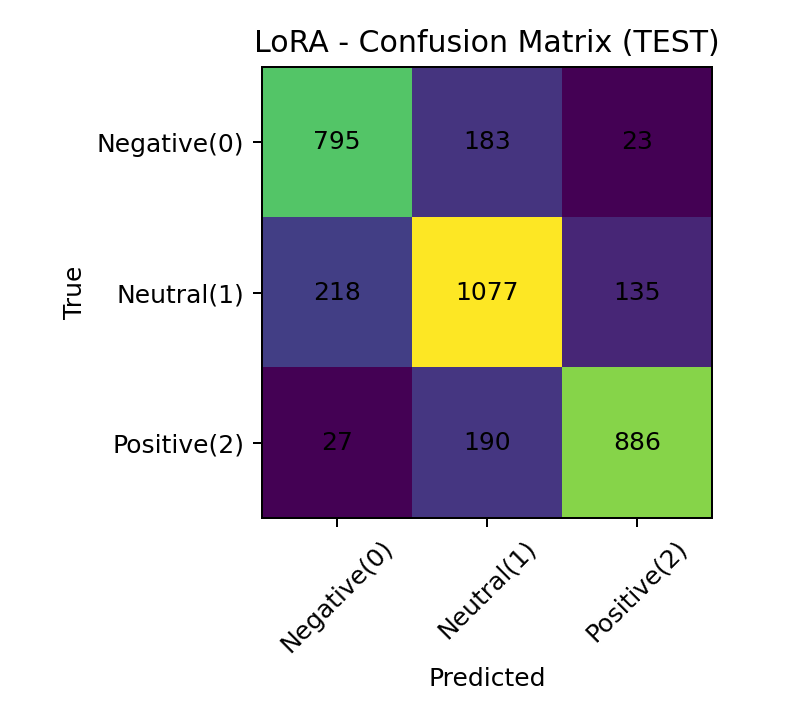

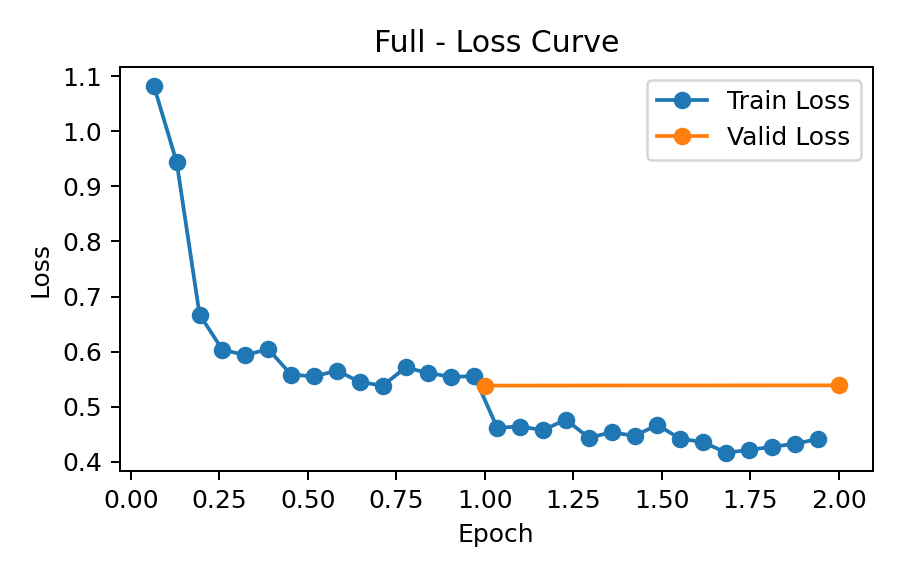

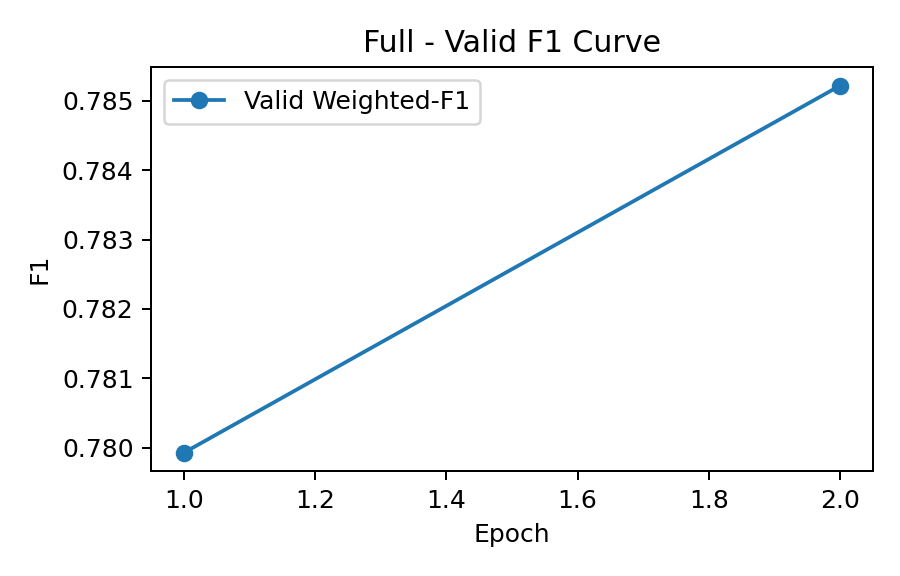

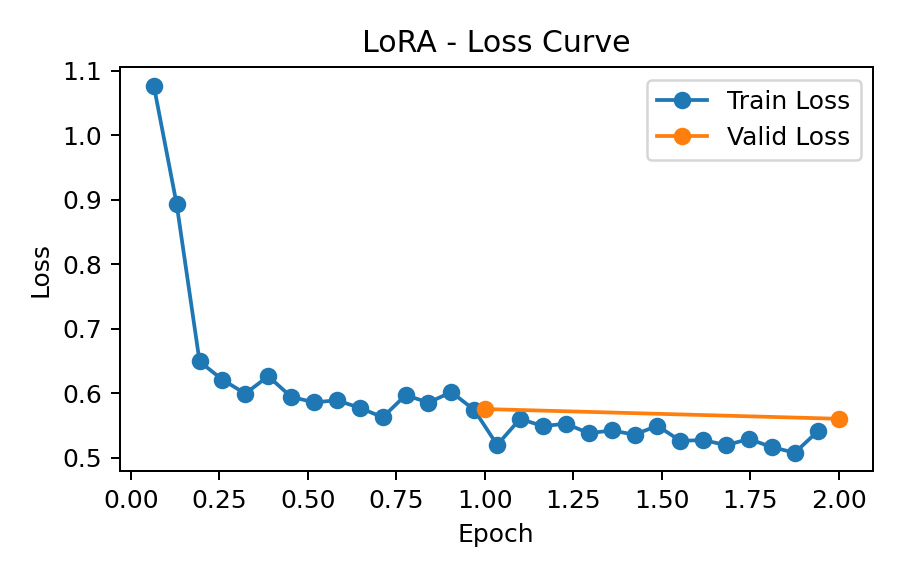

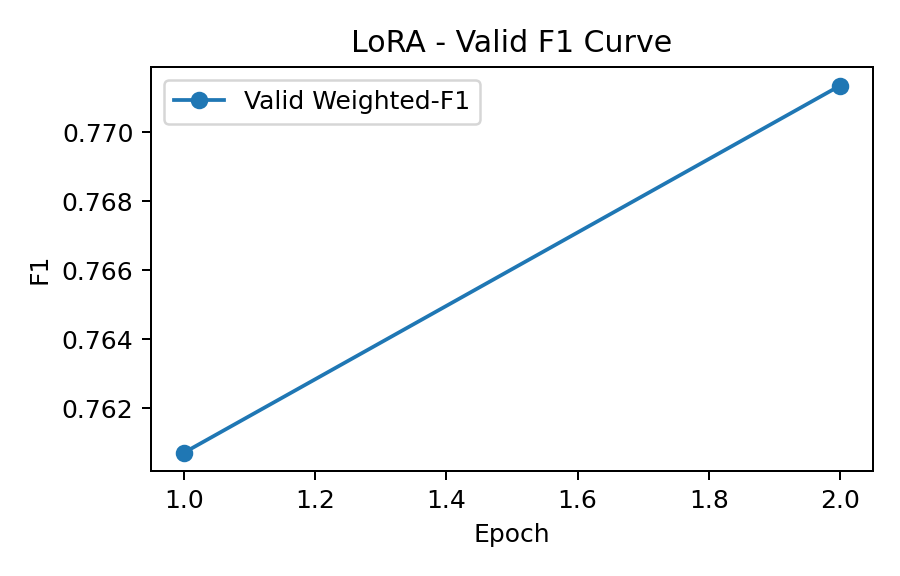

In [2]:
import os
from IPython.display import Image, display
for f in os.listdir('/kaggle/working'):
    if f.endswith('.png'):
        print(f)
display(Image('full_confusion_test.png'))
display(Image('lora_confusion_test.png'))
display(Image('full_loss_curve.png'))
display(Image('full_f1_curve.png'))
display(Image('lora_loss_curve.png'))
display(Image('lora_f1_curve.png'))

In [3]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
y_true = np.array(test_dataset["label"])
y_full = np.array(full_preds)
y_lora = np.array(lora_preds)
def bootstrap_ci(metric_fn, y_true, y_pred, B=2000, alpha=0.05):
    n = len(y_true)
    stats = []
    rng = np.random.default_rng(2002)
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    stats = np.sort(stats)
    lo = stats[int((alpha/2)*B)]
    hi = stats[int((1-alpha/2)*B)]
    return lo, hi
for name, y_hat in [("Full", y_full), ("LoRA", y_lora)]:
    acc_ci = bootstrap_ci(accuracy_score, y_true, y_hat)
    f1w_ci = bootstrap_ci(lambda a,b: f1_score(a,b,average="weighted"), y_true, y_hat)
    print(f"{name} 95% CI — Acc: [{acc_ci[0]:.4f}, {acc_ci[1]:.4f}], "
          f"Weighted-F1: [{f1w_ci[0]:.4f}, {f1w_ci[1]:.4f}]")
full_correct = (y_full == y_true)
lora_correct = (y_lora == y_true)
b = np.sum(( full_correct==1) & (lora_correct==0))  # Full correct, LoRA wrong
c = np.sum(( full_correct==0) & (lora_correct==1))  # Full wrong, LoRA correct
table = [[0, b],[c, 0]]
result = mcnemar(table, exact=True)
print(f"McNemar: b={b}, c={c}, p-value={result.pvalue:.4g}")

Full 95% CI — Acc: [0.7816, 0.8081], Weighted-F1: [0.7819, 0.8085]
LoRA 95% CI — Acc: [0.7671, 0.7946], Weighted-F1: [0.7675, 0.7950]
McNemar: b=146, c=93, p-value=0.0007357


In [5]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np, matplotlib.pyplot as plt
y_true = np.array(test_dataset["label"])
p_f, r_f, f_f, _ = precision_recall_fscore_support(y_true, full_preds, labels=[0,1,2], zero_division=0)
p_l, r_l, f_l, _ = precision_recall_fscore_support(y_true, lora_preds, labels=[0,1,2], zero_division=0)
labels = ["Negative(0)","Neutral(1)","Positive(2)"]
def bar_cmp(vals_full, vals_lora, title, fname):
    x = np.arange(len(labels)); w = 0.35
    plt.figure(figsize=(6,3))
    plt.bar(x-w/2, vals_full, width=w, label="Full FT")
    plt.bar(x+w/2, vals_lora, width=w, label="LoRA")
    plt.xticks(x, labels); plt.ylim(0,1.0)
    plt.ylabel(title); plt.title(f"{title} by Class (TEST)")
    plt.legend(); plt.tight_layout(); plt.savefig(fname, dpi=180); plt.close()
bar_cmp(p_f, p_l, "Precision", "./perclass_precision.png")
bar_cmp(r_f, r_l, "Recall",    "./perclass_recall.png")
bar_cmp(f_f, f_l, "F1",        "./perclass_f1.png")

In [6]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt, numpy as np
def overall_scores(y, yhat):
    return (accuracy_score(y,yhat),
            f1_score(y,yhat,average="weighted"),
            f1_score(y,yhat,average="macro"))
acc_f, wf1_f, mf1_f = overall_scores(y_true, full_preds)
acc_l, wf1_l, mf1_l = overall_scores(y_true, lora_preds)
metrics = ["Accuracy","Weighted-F1","Macro-F1"]
full_vals = [acc_f, wf1_f, mf1_f]; lora_vals = [acc_l, wf1_l, mf1_l]
x = np.arange(len(metrics)); w=0.35
plt.figure(figsize=(6,3))
plt.bar(x-w/2, full_vals, width=w, label="Full FT")
plt.bar(x+w/2, lora_vals, width=w, label="LoRA")
plt.xticks(x, metrics); plt.ylim(0,1.0)
plt.ylabel("Score"); plt.title("Overall Metrics (TEST)")
plt.legend(); plt.tight_layout(); plt.savefig("./overall_bar.png", dpi=180); plt.close()

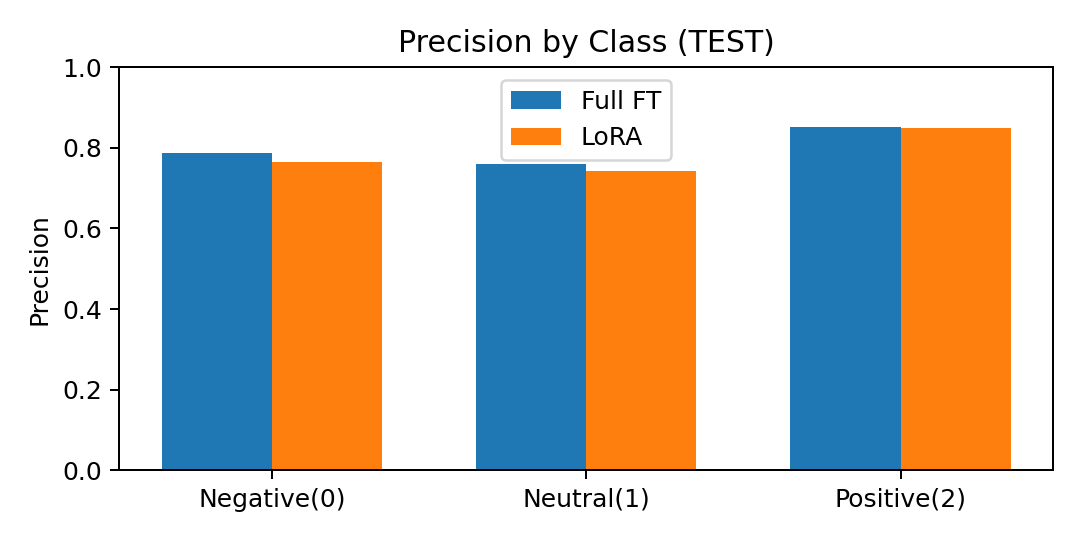

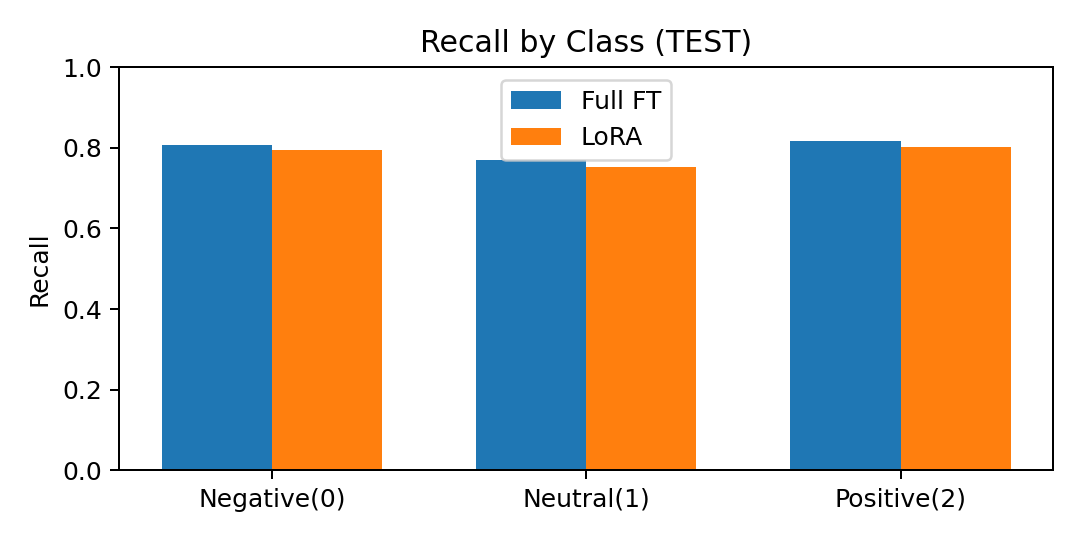

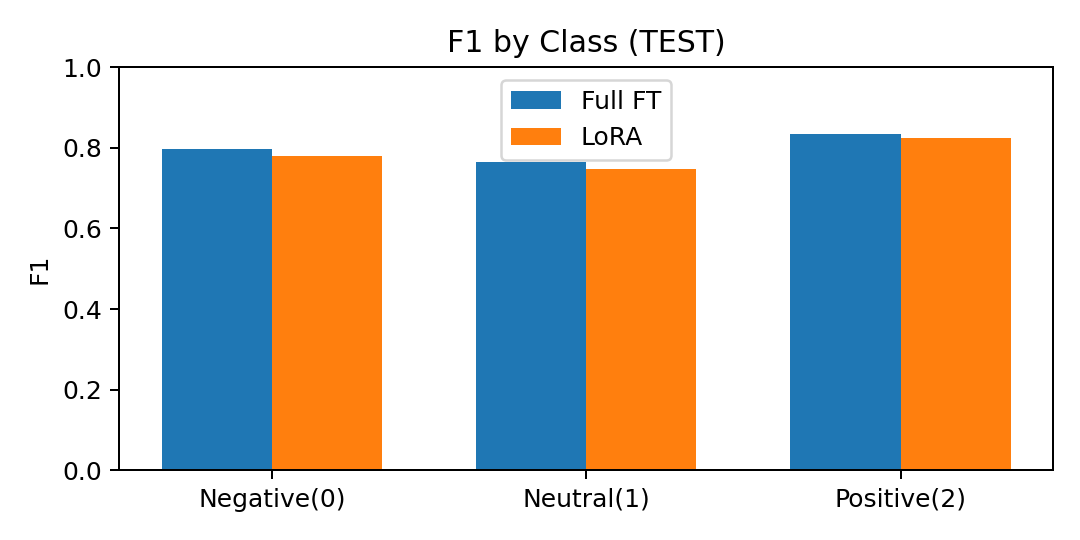

In [9]:
display(Image('perclass_precision.png'))
display(Image('perclass_recall.png'))
display(Image('perclass_f1.png'))

In [10]:
import numpy as np
import pandas as pd
import torch
id2label = {0:"Negative(0)", 1:"Neutral(1)", 2:"Positive(2)"}
def softmax_np(z):
    z = torch.tensor(z)
    return torch.softmax(z, dim=1).cpu().numpy()
probs_full = softmax_np(full_test_out.predictions)
probs_lora = softmax_np(lora_test_out.predictions)
y_true = np.array(test_dataset["label"])
texts  = ds["test"]["text"] 
df = pd.DataFrame({
    "text": texts,
    "label_true_id": y_true,
    "label_true": [id2label[i] for i in y_true],
    "full_pred_id": full_preds,
    "full_pred": [id2label[i] for i in full_preds],
    "full_confidence": probs_full.max(axis=1),
    "lora_pred_id": lora_preds,
    "lora_pred": [id2label[i] for i in lora_preds],
    "lora_confidence": probs_lora.max(axis=1),})
df["full_correct"] = (df["label_true_id"]==df["full_pred_id"])
df["lora_correct"] = (df["label_true_id"]==df["lora_pred_id"])
df.head()

,text,label_true_id,label_true,full_pred_id,full_pred,full_confidence,lora_pred_id,lora_pred,lora_confidence,full_correct,lora_correct
0,Last session of the day http://twitpic.com/67ezh,1,Neutral(1),1,Neutral(1),0.969529,1,Neutral(1),0.925512,True,True
1,Shanghai is also really exciting (precisely -...,2,Positive(2),2,Positive(2),0.977073,2,Positive(2),0.976740,True,True
2,"Recession hit Veronique Branquinho, she has to...",0,Negative(0),0,Negative(0),0.974660,0,Negative(0),0.974764,True,True
3,happy bday!,2,Positive(2),2,Positive(2),0.982270,2,Positive(2),0.984703,True,True
4,http://twitpic.com/4w75p - I like it!!,2,Positive(2),2,Positive(2),0.979002,2,Positive(2),0.971626,True,True


In [11]:
K = 10
full_errors = df[~df["full_correct"]].copy().sort_values("full_confidence", ascending=False)
lora_errors = df[~df["lora_correct"]].copy().sort_values("lora_confidence", ascending=False)
cols = ["text","label_true","full_pred","full_confidence","lora_pred","lora_confidence"]
full_errors_top = full_errors[cols].head(K)
lora_errors_top = lora_errors[cols].head(K)
full_errors_top

,text,label_true,full_pred,full_confidence,lora_pred,lora_confidence
3422,My younger sister flies in next week for a two...,Neutral(1),Positive(2),0.981104,Positive(2),0.975493
2474,"jfc, it needs to be the 23rd. i will have been...",Neutral(1),Positive(2),0.977442,Positive(2),0.970565
815,Wango tango!!! Good night all,Neutral(1),Positive(2),0.977280,Positive(2),0.959545
2918,my poor baby girl is poorly x,Neutral(1),Negative(0),0.977056,Negative(0),0.970581
2658,soo **** stressed out...I think I could possib...,Positive(2),Negative(0),0.976436,Negative(0),0.982942
2305,staying home because I`m badass.,Positive(2),Negative(0),0.975987,Negative(0),0.988870
1075,"ohh snapp, have fun",Neutral(1),Positive(2),0.975955,Positive(2),0.982260
2485,"Friday Night Magic last night, I lost so bad ...",Neutral(1),Negative(0),0.975556,Negative(0),0.964807
2407,I`m loving Please Don`t Leave Me by Pink!,Neutral(1),Positive(2),0.973924,Positive(2),0.947528
3126,At the bus stop there`s always a big pile of l...,Positive(2),Negative(0),0.972323,Negative(0),0.964170


In [12]:
disagree_full_better = df[(df["full_correct"]) & (~df["lora_correct"])].copy()
disagree_lora_better = df[(~df["full_correct"]) & (df["lora_correct"])].copy()
disagree_full_better_view = disagree_full_better.sort_values("full_confidence", ascending=False).head(20)[
    ["text","label_true","full_pred","full_confidence","lora_pred","lora_confidence"]]
disagree_lora_better_view = disagree_lora_better.sort_values("lora_confidence", ascending=False).head(20)[
    ["text","label_true","full_pred","full_confidence","lora_pred","lora_confidence"]]
disagree_full_better_view

,text,label_true,full_pred,full_confidence,lora_pred,lora_confidence
2770,omg that was my twin sister`s fav song,Positive(2),Positive(2),0.944983,Neutral(1),0.714148
886,what a beautiful day not to got to my first class,Positive(2),Positive(2),0.925817,Neutral(1),0.513927
2308,My Birthday weekend! cant find where my ex hid...,Negative(0),Negative(0),0.906847,Neutral(1),0.548830
833,Flickr pics Chester Zoo: danwtmoon posted a ph...,Neutral(1),Neutral(1),0.898430,Positive(2),0.522431
3118,I have popcorn and fruitcake now...but it`s j...,Neutral(1),Neutral(1),0.878438,Negative(0),0.503375
2985,59 may be my new FAV number!!!,Positive(2),Positive(2),0.876493,Neutral(1),0.931674
1034,crying to A Walk To Remember as usual,Negative(0),Negative(0),0.865190,Neutral(1),0.479005
1016,"no work today! went shopping, and now relaxing...",Positive(2),Positive(2),0.862325,Neutral(1),0.535191
3521,munchin BACON BUTTIES! woohoo!! my faves!!!,Positive(2),Positive(2),0.858775,Neutral(1),0.495494
1658,get it right! I think I am obsessed with Hydes...,Positive(2),Positive(2),0.844024,Neutral(1),0.457154


In [13]:
def sample_errors_by_class(df_src, pred_col, conf_col, true_id, n=5):
    sub = df_src[(df_src["label_true_id"]==true_id) & (~df_src[pred_col.replace("_pred","_correct")])].copy()
    return sub.sort_values(conf_col, ascending=False).head(n)[["text","label_true",pred_col,conf_col]]
print("Full wrong（True=Neutral）")
sample_errors_by_class(df, "full_pred", "full_confidence", true_id=1, n=8)

Full wrong（True=Neutral）


,text,label_true,full_pred,full_confidence
3422,My younger sister flies in next week for a two...,Neutral(1),Positive(2),0.981104
2474,"jfc, it needs to be the 23rd. i will have been...",Neutral(1),Positive(2),0.977442
815,Wango tango!!! Good night all,Neutral(1),Positive(2),0.977280
2918,my poor baby girl is poorly x,Neutral(1),Negative(0),0.977056
1075,"ohh snapp, have fun",Neutral(1),Positive(2),0.975955
2485,"Friday Night Magic last night, I lost so bad ...",Neutral(1),Negative(0),0.975556
2407,I`m loving Please Don`t Leave Me by Pink!,Neutral(1),Positive(2),0.973924
2621,"First surprise birthday ever, best night I`ve ...",Neutral(1),Positive(2),0.969658


In [15]:
df.to_csv("test_predictions_full_lora.csv", index=False)
full_errors.to_csv("full_errors.csv", index=False)
lora_errors.to_csv("lora_errors.csv", index=False)
disagree_full_better.to_csv("disagree_full_better.csv", index=False)
disagree_lora_better.to_csv("disagree_lora_better.csv", index=False)
print("Saved CSVs in working dir.")

Saved CSVs in working dir.
